In [19]:
# Import the lib 
import tensorflow as tf
import inspect
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
tf.set_random_seed(0)
np.random.seed(0)

In [7]:
# my layers and activation functions
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater_equal(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less(x,0),tf.float64) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float64)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x):   return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x):   return x
def d_tf_iden(x): return x

class CNN():

    def __init__(self,k,inc,out,stddev=0.05,which_reg=0,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),
        filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.which_reg == 0:   grad = grad
        if self.which_reg == 0.5: grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
        if self.which_reg == 1:   grad = grad + lamda * tf.sign(self.w)
        if self.which_reg == 1.5: grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
        if self.which_reg == 2:   grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
        if self.which_reg == 2.5: grad = grad + lamda * 2.0 * self.w
        if self.which_reg == 3:   grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
        if self.which_reg == 4:   grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w
    
class FNN():

    def __init__(self,inc,outc,act=tf_elu,d_act=d_tf_elu,special_init=False,which_reg=0.0):
      
        self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float32))
        self.b = tf.Variable(tf.zeros        ([outc],dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.m_b,self.v_b = tf.Variable(tf.zeros_like(self.b)),tf.Variable(tf.zeros_like(self.b))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w) + self.b
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient=None,which_reg=0):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad  = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_b= tf.reduce_mean(grad_middle,axis=0)
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        # === Reg ===
        if self.which_reg == 0:
            grad  = grad
            grad_b= grad_b

        if self.which_reg == 0.5:
            grad  = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
            grad_b= grad_b+lamda * (tf.sqrt(tf.abs(self.b))) * (1.0/tf.sqrt(tf.abs(self.b)+ 10e-5)) * tf.sign(self.b)

        if self.which_reg == 1:
            grad = grad   + lamda * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.sign(self.b)

        if self.which_reg == 1.5:
            grad = grad   + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
            grad_b=grad_b + lamda * 1.0/(tf.sqrt(tf.square(self.b) + 10e-5)) * self.b

        if self.which_reg == 2:
            grad = grad  + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
            grad_b=grad_b+ lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.b))+ 10e-5)) * tf.abs(self.b) * tf.sign(self.b)

        if self.which_reg == 2.5:
            grad = grad   + lamda * 2.0 * self.w
            grad_b=grad_b + lamda * 2.0 * self.b

        if self.which_reg == 3:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.b),2) * tf.sign(self.b)

        if self.which_reg == 4:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.b),3) * tf.sign(self.b)

        update_w = []

        # Update the Weight First
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))

        # Update the Bias later
        update_w.append(tf.assign(self.m_b,self.m_b*beta1 + (1-beta1) * (grad_b)   ))
        update_w.append(tf.assign(self.v_b,self.v_b*beta2 + (1-beta2) * (grad_b ** 2)   ))
        m_hat_b = self.m_b / (1-beta1)
        v_hat_b = self.v_b / (1-beta2)
        adam_middle_b = m_hat_b *  learning_rate/(tf.sqrt(v_hat_b) + adam_e)
        update_w.append(tf.assign(self.b,tf.subtract(self.b,adam_middle_b )))

        return grad_pass,update_w    

In [20]:
# Read all of the texture image data
PathDicom =  '../../DataSet/texture/images/'
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".jpg" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

lstFilesDCM= shuffle(lstFilesDCM)
train_data = np.asarray(Image.open(lstFilesDCM[0]).resize((224,224)))[None,:,:,:]
for i in range(1,500):
    temp       = np.asarray(Image.open(lstFilesDCM[i]).resize((224,224)))[None,:,:,:]
    train_data = np.vstack((train_data,temp))
print(train_data.shape)

(500, 224, 224, 3)


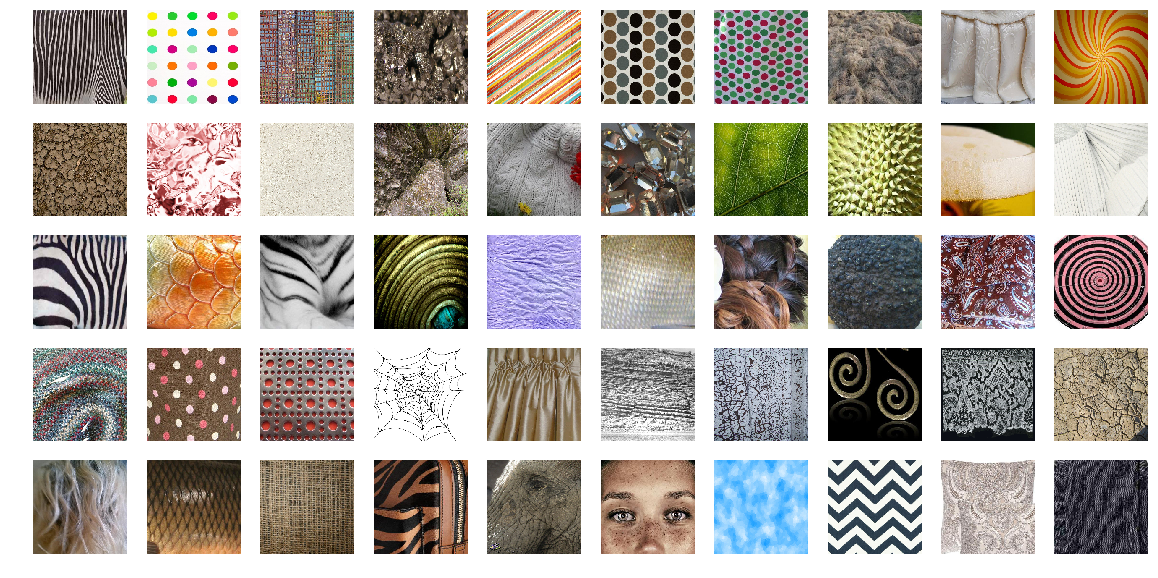

In [27]:
# Show the random images
def show_images(data):
    fig=plt.figure(figsize=(20, 10))
    columns = 10; rows = 5
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(np.squeeze(data[i-1]))
        plt.grid(False)
        plt.axis('off')
    plt.show()
show_images(shuffle(train_data))

In [28]:
# set the path for vgg 16
vgg16_npy_path = "../../pretrained/vgg16.npy"

In [31]:
# Create the VGG class : https://github.com/machrisaa/tensorflow-vgg/blob/master/test_vgg16.py
VGG_MEAN = [103.939, 116.779, 123.68]
class Vgg16:
    
    def __init__(self, vgg16_npy_path=None):
        
        if vgg16_npy_path is None:
            path = inspect.getfile(Vgg16)
            path = os.path.abspath(os.path.join(path, os.pardir))
            path = os.path.join(path, "vgg16.npy")
            vgg16_npy_path = path
            print(path)

        self.data_dict = np.load(vgg16_npy_path, encoding='latin1').item()
        print("npy file loaded")

    def build(self, rgb):
        """
        load variable from npy to build the VGG
        :param rgb: rgb image [batch, height, width, 3] values scaled [0, 1]
        """

        start_time = time.time()
        print("build model started")
        rgb_scaled = rgb * 255.0

        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=rgb_scaled)
        assert red.get_shape().as_list()[1:] == [224, 224, 1]
        assert green.get_shape().as_list()[1:] == [224, 224, 1]
        assert blue.get_shape().as_list()[1:] == [224, 224, 1]
        bgr = tf.concat(axis=3, values=[
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ])
        assert bgr.get_shape().as_list()[1:] == [224, 224, 3]

        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1   = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2   = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.pool3   = self.max_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.pool4   = self.max_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        self.pool5   = self.max_pool(self.conv5_3, 'pool5')

        self.fc6   = self.fc_layer(self.pool5, "fc6")
        assert self.fc6.get_shape().as_list()[1:] == [4096]
        self.relu6 = tf.nn.relu(self.fc6)

        self.fc7   = self.fc_layer(self.relu6, "fc7")
        self.relu7 = tf.nn.relu(self.fc7)

        self.fc8   = self.fc_layer(self.relu7, "fc8")
        self.prob  = tf.nn.softmax(self.fc8, name="prob")

        self.data_dict = None
        print(("build model finished: %ds" % (time.time() - start_time)))

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)
            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')
            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)
            relu = tf.nn.relu(bias)
            return relu

    def fc_layer(self, bottom, name):
        with tf.variable_scope(name):
            shape = bottom.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(bottom, [-1, dim])

            weights = self.get_fc_weight(name)
            biases = self.get_bias(name)

            # Fully connected layer. Note that the '+' operation automatically broadcasts the biases.
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name="weights")

In [51]:
# Load the model / hyper
batch_size = 50
my_vgg_tf  = Vgg16(vgg16_npy_path)

npy file loaded


In [52]:
# create the graph
vgg_input_data  = tf.placeholder(shape=[batch_size,224,224,3],dtype=tf.float32)
my_vgg_tf.build(vgg_input_data);
prediction     = my_vgg_tf.conv5_3
gradient_input = tf.gradients(prediction,[vgg_input_data])

build model started
build model finished: 5s


In [ ]:
# create interactive sess 
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

all_gradients = sess.run(gradient_input,
     feed_dict={vgg_input_data:train_data[:batch_size]})[0]

for currnet_index in range(batch_size,len(train_data),batch_size):
    current_data  = train_data[currnet_index:currnet_index+batch_size]
    sess_results  = sess.run(gradient_input,feed_dict={vgg_input_data:current_data})[0]
    all_gradients = np.vstack((all_gradients,sess_results))
print('Done Final Gradient Shape: ',all_gradients.shape)

In [ ]:
# show the gradient min max mean std 
print(all_gradients.min())
print(all_gradients.max())
print(all_gradients.mean())
print(all_gradients.std())
all_gradients_norm = (all_gradients-all_gradients.min((1,2))[:,None,None,:] )/\
                     (all_gradients.max((1,2))-all_gradients.min((1,2))+1e-10)[:,None,None,:]
print(all_gradients_norm.min())
print(all_gradients_norm.max())
print(all_gradients_norm.mean())
print(all_gradients_norm.std())

In [ ]:
# view the gradietns
show_images(all_gradients_norm)
show_images(train_data)

In [110]:
# tf Graph Input
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(1,0, name="weight",dtype=tf.float32)
b = tf.Variable(0.0, name="bias"  ,dtype=tf.float32)

# Construct a linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = pred-Y

dc_dw, dc_db = tf.gradients(cost, [W, b])

In [111]:
sess.run(tf.global_variables_initializer())
sess_variables = [X,Y,W,b,pred,cost,dc_dw,dc_db]
sess_results = sess.run(sess_variables,feed_dict={X:3,Y:5})
for name,item in zip(sess_results,sess_variables):
    print(str(name),' : ',item)

3.0  :  Tensor("Placeholder_54:0", dtype=float32)
5.0  :  Tensor("Placeholder_55:0", dtype=float32)
1.0  :  <tf.Variable 'weight_7:0' shape=() dtype=float32_ref>
0.0  :  <tf.Variable 'bias_7:0' shape=() dtype=float32_ref>
3.0  :  Tensor("Add_3:0", dtype=float32)
-2.0  :  Tensor("sub_24:0", dtype=float32)
3.0  :  Tensor("gradients_2/Mul_5_grad/Reshape_1:0", shape=(), dtype=float32)
1.0  :  Tensor("gradients_2/Add_3_grad/Reshape_1:0", shape=(), dtype=float32)


# Reference
1. machrisaa/tensorflow-vgg. (2018). GitHub. Retrieved 24 October 2018, from https://github.com/machrisaa/tensorflow-vgg/blob/master/test_vgg16.py
2. tf.gradients | TensorFlow. (2018). TensorFlow. Retrieved 24 October 2018, from https://www.tensorflow.org/api_docs/python/tf/gradients
3. TensorFlow, H. (2018). How tf.gradients work in TensorFlow. Stack Overflow. Retrieved 24 October 2018, from https://stackoverflow.com/questions/41822308/how-tf-gradients-work-in-tensorflow
4. DICOM in Python: Importing medical image data into NumPy with PyDICOM and VTK. (2014). PyScience. Retrieved 24 October 2018, from https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/
5. plots, H. (2018). Hiding axis text in matplotlib plots. Stack Overflow. Retrieved 24 October 2018, from https://stackoverflow.com/questions/2176424/hiding-axis-text-in-matplotlib-plots
6.